In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')

from src.emotion.analysis.data_preprocessing import (
    DataPreprocessor,
    LinearInterpolator,
    RollingAverageSmoother,
)

%matplotlib inline

In [3]:
folder = '/home/moritz/Workspace/masterthesis/data/identities/'
df = pd.read_csv(folder + 'team_20/2023-01-10/clip_0_6515_7670.csv')

In [4]:
preprocessing_pipeline = [
    LinearInterpolator(),
    RollingAverageSmoother(
        window_size=125,
        cols=["Brightness"],
    ),
]

preprocessor = DataPreprocessor(preprocessing_pipeline)
pre_df = preprocessor.preprocess_data(df)

pre_df.head(10)

,Frame,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,Brightness,ClassID
0,0,0.888322,963.261841,609.813171,0.006095,0.025079,0.089205,0.181192,0.000575,0.005860,0.691994,140.328863,person_id1
1,1,0.888457,965.719287,611.234277,0.005633,0.022757,0.201751,0.165633,0.000526,0.004948,0.598751,140.304807,person_id1
2,2,0.888591,968.176733,612.655383,0.005172,0.020436,0.314298,0.150073,0.000478,0.004036,0.505508,140.285702,person_id1
3,3,0.888726,970.634180,614.076489,0.004710,0.018114,0.426844,0.134514,0.000429,0.003124,0.412264,140.271321,person_id1
4,4,0.888861,973.091626,615.497595,0.004249,0.015793,0.539390,0.118954,0.000381,0.002212,0.319021,140.259383,person_id1
5,5,0.888996,975.549072,616.918701,0.003787,0.013471,0.651937,0.103395,0.000332,0.001300,0.225778,140.249778,person_id1
6,6,0.882867,982.815259,620.123218,0.006741,0.014026,0.650736,0.087463,0.000656,0.001639,0.238739,140.242406,person_id1
7,7,0.876738,990.081445,623.327734,0.009696,0.014581,0.649536,0.071530,0.000980,0.001978,0.251700,140.237171,person_id1
8,8,0.870610,997.347632,626.532251,0.012650,0.015135,0.648335,0.055598,0.001303,0.002317,0.264661,140.233982,person_id1
9,9,0.864481,1004.613818,629.736768,0.015604,0.015690,0.647134,0.039666,0.001627,0.002657,0.277621,140.232096,person_id1


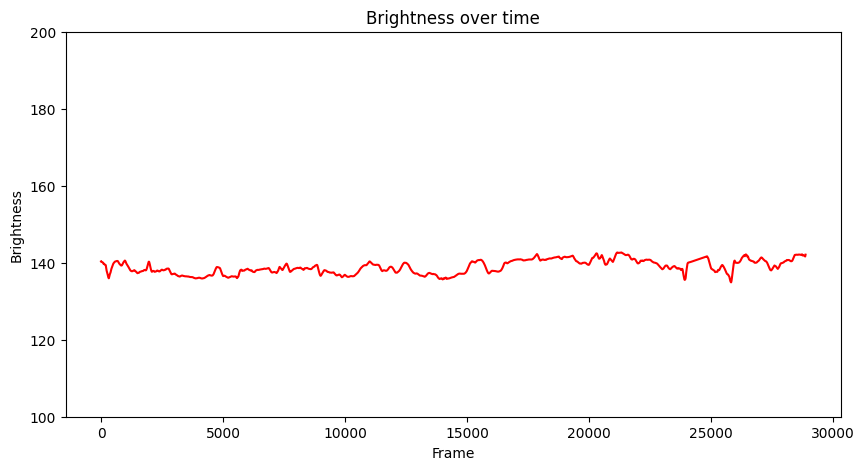

In [5]:
person_df = pre_df[pre_df["ClassID"] == "person_id1"]

# create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# plot the Brightness column for person_id1 using sns.lineplot()
sns.lineplot(x="Frame", y="Brightness", data=person_df, color="red")

# set the title, x-label, y-label, and y-limits of the plot
ax.set_title("Brightness over time")
ax.set_xlabel("Frame")
ax.set_ylabel("Brightness")
ax.set_ylim(100, 200)

plt.show()

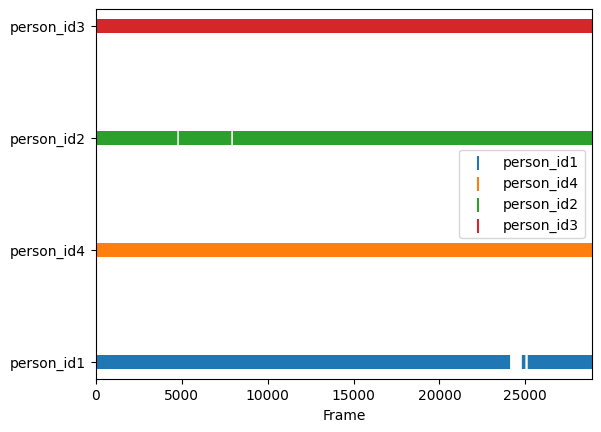

In [6]:
# get the unique ClassIDs
class_ids = df['ClassID'].unique()

# create a figure and axis object
fig, ax = plt.subplots()

# plot the presence of each ClassID in each frame
for i, class_id in enumerate(class_ids):
    is_present = df['ClassID'] == class_id
    ax.scatter(df[is_present]['Frame'], [i] * len(df[is_present]), marker='|', s=100, label=class_id)

# set the y-axis ticks and labels
ax.set_yticks(range(len(class_ids)))
ax.set_yticklabels(class_ids)

# set the x-axis label and limits
ax.set_xlabel('Frame')
ax.set_xlim(0, df['Frame'].max() + 1)

# show the legend and plot
ax.legend()
plt.show()

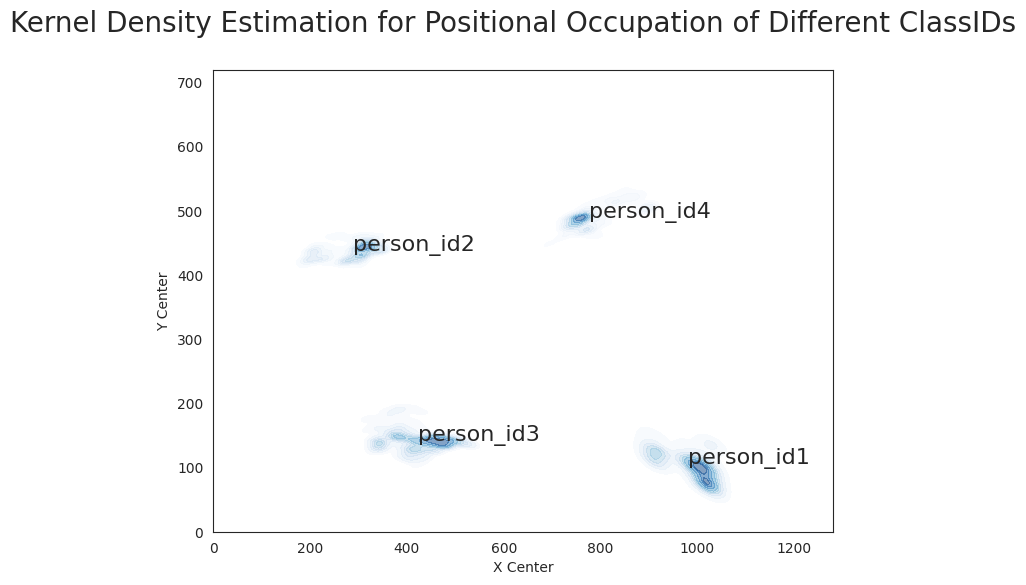

In [16]:
import numpy as np
from scipy.stats import gaussian_kde

stds = pd.DataFrame(columns=["Std_X_Center", "Std_Y_Center"])
kdes = {}
# Compute kernel density estimation for each ClassID
for class_id in df["ClassID"].unique():
    # Select the data for the current ClassID
    data = df[df["ClassID"] == class_id][["x_center", "y_center"]]
    
    # Rotate the positions for 180 degrees around x-axis
    data["y_center"] = data["y_center"].apply(lambda y: -y) + 720

    # Compute the kernel density estimation
    k = gaussian_kde(data.T)

    # Compute the standard deviation of the KDE in each direction
    x_std = np.sqrt(k.covariance[0, 0])
    y_std = np.sqrt(k.covariance[1, 1])

    stds.loc[class_id] = [x_std, y_std]

    x, y = np.mgrid[
        data["x_center"].min() : data["x_center"].max() : 100j,
        data["y_center"].min() : data["y_center"].max() : 100j,
    ]

    positions = np.vstack([x.ravel(), y.ravel()])
    z = np.reshape(k(positions).T, x.shape)

    # Store the KDE in a dictionary
    kdes[class_id] = z


# Plot the KDEs in a single plot
fig, ax = plt.subplots(figsize=(8, 6))

for class_id, kde in kdes.items():
    sns.kdeplot(
        ax=ax,
        data=df[df["ClassID"] == class_id],
        x="x_center",
        y="y_center",
        cmap="Blues",
        alpha=0.5,
        thresh=0.05,
        fill=True,
    )
    ax.text(
        x=df[df["ClassID"] == class_id]["x_center"].mean(),
        y=df[df["ClassID"] == class_id]["y_center"].mean(),
        s=class_id,
        fontsize=16,
    )

fig.suptitle(
    "Kernel Density Estimation for Positional Occupation of Different ClassIDs",
    fontsize=20,
)
ax.set_xlabel("X Center")
ax.set_ylabel("Y Center")
ax.set_xlim(0, 1280)
ax.set_ylim(0, 720)

plt.show()